# Autocodificadors: Eliminar soroll d'imatges amb Tensorflow i Keras

L'objectiu d'aquest cas d'ús és eliminar soroll d'imatges en blanc i negre.
Per a fer-ho, farem ús d'un autocodificador implementat amb les llibreries de
Tensorflow i Keras.

In [ ]:
from keras.datasets import mnist, fashion_mnist, imdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Obtenim el *dataset* de keras. Específicament, farem servir el *dataset* MNIST, que conté imatges que representen dígits manuscrits del 0 al 9 en blanc i negre.

In [ ]:
#El primer que fem, és llegir el dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

Una vegada tenim el *dataset*, analitzarem el nombre d'instàncies que tenim

In [ ]:
# Mides del conjunt de dades.
print("Mida de les característiques d'entrenament = ",X_train.shape)
print("Mida de les etiquetes d'entrenament = ",y_train.shape)
print("Mida de les característiques de validació = ",X_test.shape)
print("Mida de les etiquetes de validació = ",y_test.shape)

Mida de les característiques d'entrenament =  (60000, 28, 28)
Mida de les etiquetes d'entrenament =  (60000,)
Mida de les característiques de validació =  (10000, 28, 28)
Mida de les etiquetes de validació =  (10000,)


Ara analitzarem les dades del conjunt.

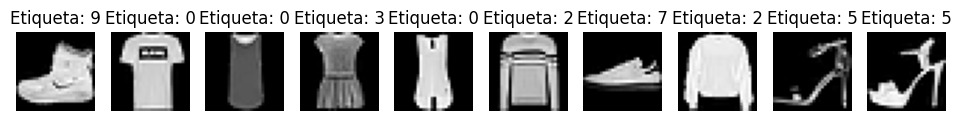

In [ ]:
# Mostrem les 10 primeres imatges del dataset.
nombre_imatges_mostrar = 10

plt.figure(figsize=(12, 4))
for i in range(nombre_imatges_mostrar):
    plt.subplot(1, nombre_imatges_mostrar, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title("Etiqueta: {}".format(y_train[i]))
    plt.axis('off')


Ara analitzarem si tenim el mateix nombre d'imatges per a qualsevol tipus de dígit.

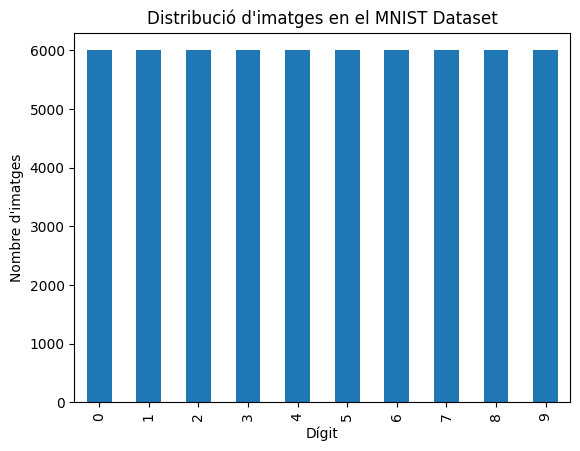

In [ ]:
# Creem un dataframe amb les etiquetes de les imatges d'entrenament.
df = pd.DataFrame({'Label': y_train})

# Comptem el nombre d'imatges que tenim de cada dígit
nombre_per_classe = df['Label'].value_counts().sort_index()

nombre_per_classe.plot(kind='bar')
plt.xlabel('Dígit')
plt.ylabel("Nombre d'imatges")
plt.title("Distribució d'imatges en el MNIST Dataset")
plt.show()

In [ ]:
print("El valor màxim del píxel d'una imatge és: {}".format(X_train.max()))
print("El valor mínim del píxel d'una imatge és: {}".format(X_train.min()))

El valor màxim del píxel d'una imatge és: 255
El valor mínim del píxel d'una imatge és: 0


Com farem servir un *autoencoder*, que s'entrenarà de manera no supervisada, no ens farà falta fer servir les etiquetes de cada classe. Així, ens guardem les característiques (imatges) en una variable amb un nom més intuïtiu.

In [ ]:
#Donem un nom més intuitiu a les variables que emmagatzemen les nostres dades.
imatges_entrenament = X_train
imatges_test = X_test

# Hem vist que els valors de les imatges anaven entre 0 (negre) i 255 (blanc).
# Normalitzem les imatges per a què tinguin valors entre 0 i 1.
imatges_entrenament = imatges_entrenament.astype('float32') / 255.0
imatges_test = imatges_test.astype('float32') / 255.0
print("El valor màxim del píxel d'una imatge d'entrenament és: {}".format(imatges_entrenament.max()))
print("El valor mínim del píxel d'una imatge d'entrenament és: {}".format(imatges_entrenament.min()))
print("El valor màxim del píxel d'una imatge de validació és: {}".format(imatges_test.max()))
print("El valor mínim del píxel d'una imatge de validació és: {}".format(imatges_test.min()))

El valor màxim del píxel d'una imatge d'entrenament és: 1.0
El valor mínim del píxel d'una imatge d'entrenament és: 0.0
El valor màxim del píxel d'una imatge de validació és: 1.0
El valor mínim del píxel d'una imatge de validació és: 0.0


Ara que ja tenim les dades normalitzades, procedirem a aplicar soroll per tal d'entrenar l'*autoencoder*.

In [ ]:
factor_soroll = 0.5

# Sumem el factor de soroll multiplicat per valors generats aleatòriament seguint una
# distribució normal amb mitjana zero i desviació estàndard 1.
imatges_entrenament_sorolloses = imatges_entrenament + factor_soroll * np.random.normal(size=imatges_entrenament.shape)
imatges_test_sorolloses = imatges_test + factor_soroll  * np.random.normal(size=imatges_test.shape)

In [ ]:
# Després de sumar el soroll, por ser que hi hagi valors que estiguin fora del rang [0, 1],
# per a evitar-ho, forcem que les dades d'entrada per entrenar l'autoencoder estiguin
# dins d'aquest rang.
imatges_entrenament_sorolloses = np.clip(imatges_entrenament_sorolloses, 0., 1.)
imatges_test_sorolloses = np.clip(imatges_test_sorolloses, 0., 1.)

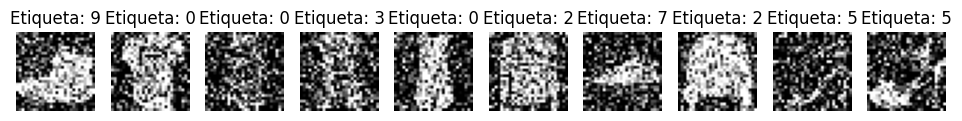

In [ ]:
# Mostrem 10 imatges amb soroll.
nombre_imatges_mostrar = 10

plt.figure(figsize=(12, 4))
for i in range(nombre_imatges_mostrar):
    plt.subplot(1, nombre_imatges_mostrar, i + 1)
    plt.imshow(imatges_entrenament_sorolloses[i], cmap='gray')
    plt.title("Etiqueta: {}".format(y_train[i]))
    plt.axis('off')

In [ ]:
# Crearem una funció per a mostrar imatges quan tinguem l'autocodificador entrenat:
# Primer mostrem les imatges originals
# Seguidament mostrem les imatges amb soroll
# Finalment, mostrem les imatges reconstruides amb l'autocodificador
def mostrar_imatges(imatges_test, imatges_test_sorolloses, imatges_sense_soroll ):
  num_samples = 5

  plt.figure(figsize=(15, 5))
  for i in range(num_samples):
      # Imatges originals
      plt.subplot(3, num_samples, i + 1)
      plt.imshow(imatges_test[i], cmap='gray')
      plt.title('Original')
      plt.axis('off')

      # Sorolloses
      plt.subplot(3, num_samples, num_samples + i + 1)
      plt.imshow(imatges_test_sorolloses[i], cmap='gray')
      plt.title('Noisy')
      plt.axis('off')

      # Sense soroll
      plt.subplot(3, num_samples, 2*num_samples + i + 1)
      plt.imshow(imatges_sense_soroll[i].reshape(28, 28), cmap='gray')
      plt.title('Denoised')
      plt.axis('off')

  plt.show()

## Primer autocodificador: *fully-connected layers*

Ara ja podem procedir a crear el nostre *autoencoder*.
La primera arquitectura que farem servir serà un *autoencoder* amb *fully-connected layers*.

Epoch 1/30
59/59 [==============================] - 3s 14ms/step - loss: 0.0817 - val_loss: 0.0472
Epoch 2/30
59/59 [==============================] - 1s 9ms/step - loss: 0.0419 - val_loss: 0.0371
Epoch 3/30
59/59 [==============================] - 0s 8ms/step - loss: 0.0329 - val_loss: 0.0291
Epoch 4/30
59/59 [==============================] - 0s 8ms/step - loss: 0.0280 - val_loss: 0.0274
Epoch 5/30
59/59 [==============================] - 0s 8ms/step - loss: 0.0259 - val_loss: 0.0258
Epoch 6/30
59/59 [==============================] - 0s 8ms/step - loss: 0.0247 - val_loss: 0.0245
Epoch 7/30
59/59 [==============================] - 0s 7ms/step - loss: 0.0238 - val_loss: 0.0238
Epoch 8/30
59/59 [==============================] - 0s 8ms/step - loss: 0.0230 - val_loss: 0.0233
Epoch 9/30
59/59 [==============================] - 0s 8ms/step - loss: 0.0224 - val_loss: 0.0224
Epoch 10/30
59/59 [==============================] - 0s 8ms/step - loss: 0.0221 - val_loss: 0.0221
Epoch 11/30
59/59 

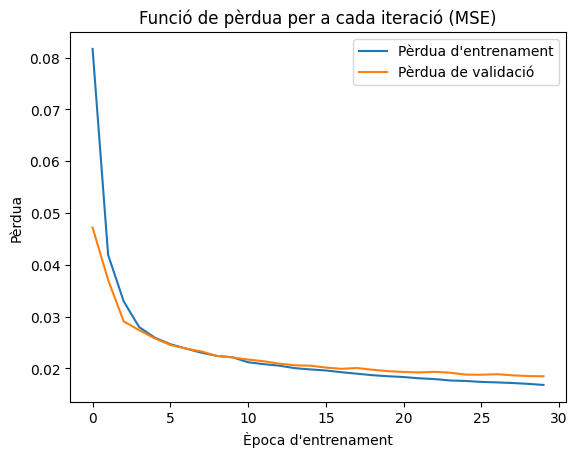

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


# Definim el codificador
encoder_input = Input(shape=(28 * 28,)) #28 x 28 = 784
encoder_dense1 = Dense(512, activation='relu')(encoder_input)
encoder_dense2 = Dense(256, activation='relu')(encoder_dense1)
encoder_dense3 = Dense(128, activation='relu')(encoder_dense2)

#Definim l'espai latent
latent_space = Dense(64, activation='relu', name='latent_space')(encoder_dense3)
encoder_model = Model(encoder_input, latent_space)


# Definim el decodificador
decoder_input = Input(shape=(64,))
decoder_dense1 = Dense(128, activation='relu')(decoder_input)
decoder_dense2 = Dense(256, activation='relu')(decoder_dense1)
decoder_dense3 = Dense(512, activation='relu')(decoder_dense2)
decoder_output = Dense(28 * 28, activation='sigmoid')(decoder_dense3)
decoder_model = Model(decoder_input, decoder_output)

# Definim el model sencer d'autocodificador
autoencoder_input = Input(shape=(28 * 28,))
encoded = encoder_model(autoencoder_input)
decoded = decoder_model(encoded)
autoencoder_model = Model(autoencoder_input, decoded)

# Compilem el model
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenem l'autocodificador
history = autoencoder_model.fit(imatges_entrenament_sorolloses.reshape(-1, 28 * 28), imatges_entrenament.reshape(-1, 28 * 28),
                      epochs=30, batch_size=1024, shuffle=True,
                      validation_data=(imatges_test_sorolloses.reshape(-1, 28 * 28), imatges_test.reshape(-1, 28 * 28)))

# Mostrem gràficament la funció de pèrdua
plt.plot(history.history['loss'], label="Pèrdua d'entrenament")
plt.plot(history.history['val_loss'], label='Pèrdua de validació')
plt.title('Funció de pèrdua per a cada iteració (MSE)')
plt.xlabel("Època d'entrenament")
plt.ylabel('Pèrdua')
plt.legend()
plt.show()



In [ ]:
# Fem servir l'autoencoder per eliminar el soroll de les imatges
imatges_sense_soroll = autoencoder_model.predict(imatges_test_sorolloses.reshape(-1, 28 * 28))

313/313 [==============================] - 1s 3ms/step


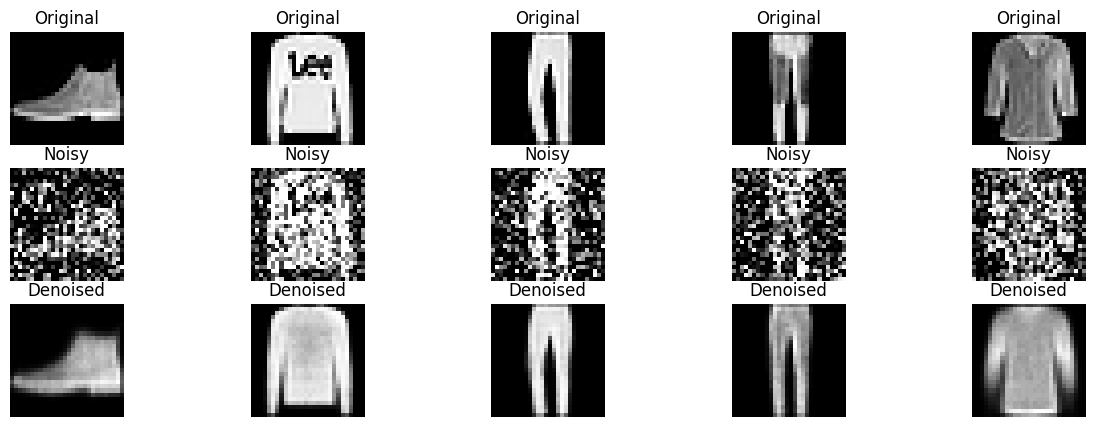

In [ ]:
mostrar_imatges(imatges_test, imatges_test_sorolloses, imatges_sense_soroll)

Hem pogut observar que el model ha fet una bona feina eliminant soroll. Tanmateix, és millorable. Ara farem el mateix però fent servir una Xarxa Neuronal Convolucional (CNN).

## Autocodificador amb capes convolucionals

Epoch 1/30
59/59 [==============================] - 4s 37ms/step - loss: 0.4840 - val_loss: 0.3481
Epoch 2/30
59/59 [==============================] - 2s 32ms/step - loss: 0.3315 - val_loss: 0.3251
Epoch 3/30
59/59 [==============================] - 2s 34ms/step - loss: 0.3191 - val_loss: 0.3188
Epoch 4/30
59/59 [==============================] - 2s 32ms/step - loss: 0.3144 - val_loss: 0.3151
Epoch 5/30
59/59 [==============================] - 2s 33ms/step - loss: 0.3114 - val_loss: 0.3124
Epoch 6/30
59/59 [==============================] - 2s 31ms/step - loss: 0.3094 - val_loss: 0.3105
Epoch 7/30
59/59 [==============================] - 2s 32ms/step - loss: 0.3077 - val_loss: 0.3091
Epoch 8/30
59/59 [==============================] - 2s 31ms/step - loss: 0.3064 - val_loss: 0.3081
Epoch 9/30
59/59 [==============================] - 2s 31ms/step - loss: 0.3054 - val_loss: 0.3069
Epoch 10/30
59/59 [==============================] - 2s 32ms/step - loss: 0.3044 - val_loss: 0.3062
Epoch 11/

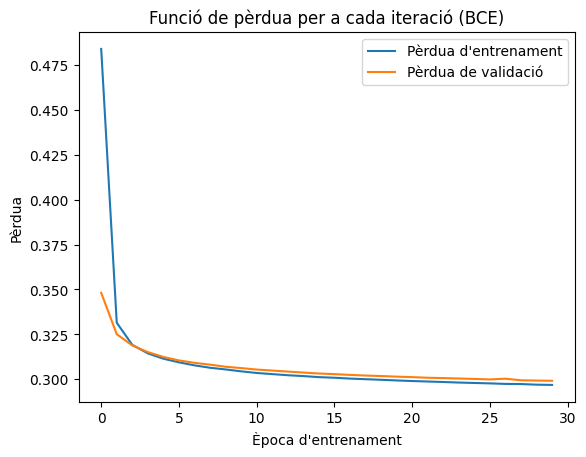

In [ ]:
# Afegim les llibreries imprescindibles per a definir capes convolucionals.
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model



# Definim l'arquitectura
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_cnn = Model(input_img, decoded)

#En aquesta ocasió, farem servir la funció de pèrdua "Binary cross entropy".
autoencoder_cnn.compile(optimizer='adam', loss='binary_crossentropy')


# Entrenem l'autocodificador.
history = autoencoder_cnn.fit(imatges_entrenament_sorolloses.reshape(-1, 28, 28, 1), imatges_entrenament.reshape(-1, 28, 28, 1),
                epochs=30, batch_size=1024, shuffle=True,
                validation_data=(imatges_test_sorolloses.reshape(-1, 28, 28, 1), imatges_test.reshape(-1, 28, 28, 1)))

# Mostrem gràficament la funció de pèrdua
plt.plot(history.history['loss'], label="Pèrdua d'entrenament")
plt.plot(history.history['val_loss'], label='Pèrdua de validació')
plt.title('Funció de pèrdua per a cada iteració (BCE)')
plt.xlabel("Època d'entrenament")
plt.ylabel('Pèrdua')
plt.legend()
plt.show()



In [ ]:
# Fem servir el nou autoencoder per a elimiar el soroll
imatges_sense_soroll_cnn = autoencoder_cnn.predict(imatges_test_sorolloses.reshape(-1, 28, 28, 1))

313/313 [==============================] - 1s 2ms/step


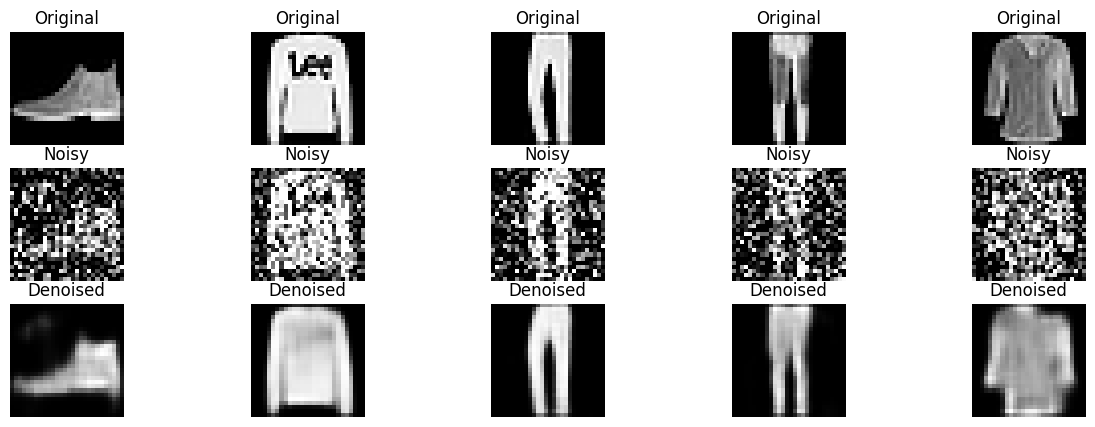

In [ ]:
mostrar_imatges(imatges_test, imatges_test_sorolloses,imatges_sense_soroll_cnn)

## Validació qualitativa amb imatges de fora del dataset

Per veure si el model ha generalitzat prou bé, mirarem com es comporta si fem servir imatges generades amb Photoshop que no siguin números.

1/1 [==============================] - 0s 18ms/step


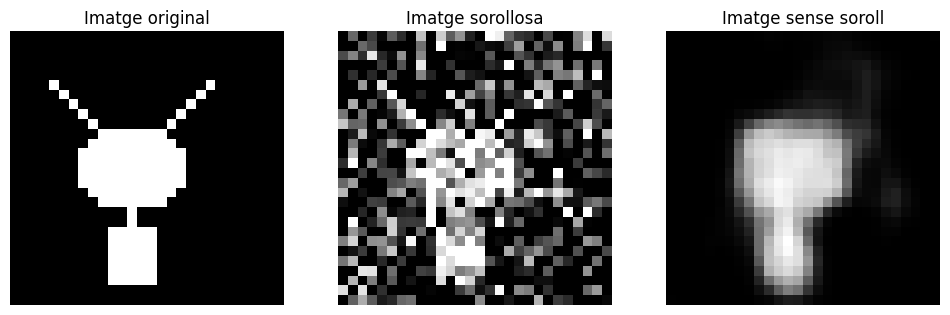

In [ ]:
from PIL import Image


# Llegim la imatge des de l'arxiu.
# Aquí podeu posar la ruta de la vostra imatge.

path_imatge = 'pick.png'
img = Image.open(path_imatge)
# La convertirem a escala de grisos ja que es van guardar en format RGB.
grayscale_image = img.convert('L')

# Converteix la imatge de PIL a NumPy array
image_array = np.array(grayscale_image)


# Normalitza la imatge
image_normalized = image_array.astype('float32') / 255.0

# Afegeix soroll a la imatge normalitzada
factor_soroll = 0.5
image_noisy = image_normalized + factor_soroll * np.random.normal(size=image_normalized.shape)

# Assegura't que els valors estiguin dins del rang [0, 1]
image_noisy = np.clip(image_noisy, 0., 1.)

# Utilitza el model entrenat per a denoising per predir la imatge sense soroll
image_denoised = autoencoder_cnn.predict(image_noisy.reshape(1, 28, 28, 1))

# Mostra les imatges original, sorollosa i denoised
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_normalized, cmap='gray')
plt.title('Imatge original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_noisy.reshape(28, 28), cmap='gray')
plt.title('Imatge sorollosa')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_denoised.reshape(28, 28), cmap='gray')
plt.title('Imatge sense soroll')
plt.axis('off')

plt.show()
